# Attention Mechanisms and Transformers

## Reference

Zhang, Aston; Lipton, Zachary C.; Li, Mu; and Smola, Alexander J.:
["Dive into Deep Learning"](https://d2l.ai/d2l-en.pdf) 
([D2L.AI](https://d2l.ai/)),
*arXiv preprint arXiv:2106.11342*,
2021.

### Code setup
 
```
conda create --name d2l python=3.9 -y
conda activate d2l
pip install torch torchvision
pip install d2l==1.0.0a1.post0
mkdir d2l-en && cd d2l-en
```
Then move this notebook inside the `d2l-en` directory to run the code cells.

Moreover, you can download and run any of the Jupyter notebooks from the [D2L.AI](https://d2l.ai/) project by:
```
curl https://d2l.ai/d2l-en.zip -o d2l-en.zip
unzip d2l-en.zip && rm d2l-en.zip
cd pytorch
jupyter notebook
```

## Attention Mechanisms

![Sam-Attention](https://rlv.zcache.com/classroom_poster_pay_attention_poster-rb0c70d0de1bc431e81cee678beaef3a8_azexq_8byvr_630.jpg)

Figure 1. Uncle Sam: I Want You to Pay Attention. - Source: [Zazzle.com](https://www.zazzle.com/classroom_poster_pay_attention_poster-228461660737425359).

**Definition:**

*Attention is the ability to observe carefully only a fraction of information presented in an object of interest.*

![ShellGame](https://ecitybeat.com/wp-content/uploads/2020/03/shell-game-times.png)

Figure 2. Shell Game. - Source: [ECityBeat.com](https://ecitybeat.com/gfps-shell-game/).

Biological mechanisms are underneath: note that *not all sensory inputs are created equal.*

Table 1. Main Elements of Attention Mechanisms.

| Query | Keys | --> | Attention pooling | Values | --> | Output |
| --- | --- | --- | --- | --- | --- | --- |
| Volitional cue | Nonvolitional cues | --> | Bias selection | Sensory inputs | --> |Result |

### Attention Pooling


![AttentionMechanisms](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/qkv.svg)

Figure 3. Attention Mechanisms Framework. - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).

- Nonparametric vs Parametric.
- Add vs Average.

A remarkable example of machine learning with nonparametric average attention pooling is the **Nadaraya-Watson** kernel regression estimator proposed in 1964, where the outputs are weighted according to the input locations through a kernel function.

### Attention Scoring Function

![ScoringAttention](https://raw.githubusercontent.com/d2l-ai/d2l-en/e8a3e203dee5b041d6461564695245f99062df90/img/attention-output.svg)

Figure 4. Scoring Attention Mechanisms Schema. - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).

- Masked softmax operation (when not all the values should be fed into attention pooling).
- Additive attention (when query and key have different length).
- Scaled dot-product attention (when query and key have same length).

### Bahdanau Attention

It uses context to selectively aggregate relevancy to different parts of the input sequence. 
The context variable is treated as an output of attention pooling.

![Seq2Seq](https://raw.githubusercontent.com/d2l-ai/d2l-en/e8a3e203dee5b041d6461564695245f99062df90/img/seq2seq-attention-details.svg)

Figure 5. Sequence to Sequence Attention Schema. - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).

The decoder hidden state of previous time steps is treated as the query, and the encoder ones at all the time steps are treated as both keys and values.

![Seq2SeqED](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/seq2seq-predict.svg)

Figure 6. Sequence to Sequence Encoder-Decoder Schema. - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

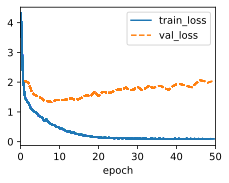

In [4]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [5]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'suis', 'calme', '.'], bleu,0.537
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


### Multi-Head Attention

It is used to combine knowledge of the same attention pooling from different representation subspaces of queries, keys, and values (when they share a common set).

This is attained by transformation and concatenation of parallel attention pooling.

![Multi-Head](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/multi-head-attention.svg)

Figure 7. Multi-Head Attention Schema. - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).

### Self-Attention

In deep learning, it is often used CNNs or RNNs to encode a sequence.

In self-attention or intra-attention, the queries, keys, and values all come from the same sequence of tokens. Then:
- Computation can be parallelized.
- The maximum path length between any combination of sequence positions is the shortest amongs the attention mechanisms.

However, the quadratic computational complexity with respect to the sequence length makes self-attention prohibitively slow for very long sequences.

![Self-Attention](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/cnn-rnn-self-attention.svg)

Figure 8. Comparing CNN, RNN, and Self-Attention Architectures. - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).

 ### Positional Encoding

It adds information (absolute or relative) on the input representations regarding the sequence order.

These encodings can be either learned or ﬁxed.

## Transformers

![TransformersFilm](https://4.bp.blogspot.com/-UH0B8bV8V1A/VIasSzVusxI/AAAAAAAAABE/zGTo-8GG0tY/s1600/Transformers-2007.jpg)

Figure 9. Transformers (2007) Film: Protect vs Destroy. - Source: [TransformersMyMovie.BlogSpot.com](https://transformersmymovie.blogspot.com/2014/12/transformers-2007-144-min-action.html).

The transformer is an instance of the encoder-decoder architecture solely based on self-attention mechanisms, but that can be used in three different modes: 
- Encoder-only: a sequence of input tokens is converted into the same number of output representations (e.g., classiﬁcation).
- Encoder-decoder: autoregressively predicts the target sequence of arbitrary length, token by token, conditional on both encoder output and decoder output.
- Decoder-only: causal attention pattern, where any target token can only attend to past and present tokens in the target sequence (token-by-token prediction that cannot attend to future tokens).

Though originally proposed for sequence to sequence learning on text data (i.e., machine translation), transformers have been pervasive in a wide range of modern deep learning applications, such as in areas of language, vision, speech, and reinforcement learning.

![Transformers](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/transformer.svg)

Figure 9. Transformer Architecture Schema. - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).

Multi-head self-attention is used for representing the input sequence and the output sequence, though the decoder has to preserve the autoregressive property via a masked version.

Both the residual connections and the layer normalization in the transformer are important for training a very deep model.

The positionwise Feed-Forward Network (FFN) in the transformer model transforms the representation at all the sequence positions using the same MLP.

In [6]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
#@save
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [8]:
#@save
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [9]:
#@save
class TransformerEncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [10]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [11]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [12]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

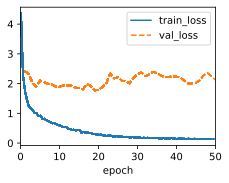

In [13]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [14]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


### Vision Transformers (ViTs)

They replace convolution by self-attention obtaining better performance for large models on large datasets (more scalability), but it decreases for image data with high resolution.

![ViTs](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/vit.svg)

Figure 10. Vision Transformers. - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).

### Large-Scale Pretraining with Transformers

For better generalized models, or even more competent generalists that can perform multiple tasks with or without adaptation, pretraining models on large data has been increasingly common.

Given larger data for pretraining, the transformer architecture performs better with an increased model size and training compute, demonstrating superior scaling behavior.

- BERT (Bidirectional Encoder Representations from Transformers) --> Encoder-only.
- T5 (Text-to-Text Transfer Transformer) --> Encoder-Decoder.
- GPT (Generative Pre-Training), GPT-2, and GPT-3 --> Decoder-only.


Thus, transformers have been extensively used in large-scale pretraining, which can be adapted to perform different tasks with model update (e.g., ﬁne tuning) or not (e.g., few shot).

Scalability of transformers suggests that better performance benefits from larger models, more training data, and more training compute.

![ImaGen](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/imagen.png)

Figure 11. Text-to-image examples by the Imagen model, whose text encoder is from T5 (figures taken from https://arxiv.org/pdf/2205.11487.pdf). - Source: [d2l-ai (GitHub)](https://github.com/d2l-ai/d2l-en).
